In [1]:
import glob
import os
import pandas as pd
os.chdir("data/shots")

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)

['shot log PHX.csv', 'shot log MIL.csv', 'shot log SAC.csv', 'shot log DAL.csv', 'shot log MIN.csv', 'shot log MEM.csv', 'shot log WAS.csv', 'shot log SAS.csv', 'shot log PHI.csv', 'shot log BOS.csv', 'combined_csv.csv', 'shot log CHA.csv', 'shot log LAC.csv', 'shot log UTA.csv', 'shot log DET.csv', 'shot log ATL.csv', 'shot log BRO.csv', 'shot log TOR.csv', 'shot log CLE.csv', 'shot log DEN.csv', 'shot log IND.csv', 'shot log POR.csv', 'shot log ORL.csv', 'shot log NYK.csv', 'shot log GSW.csv', 'shot log NOP.csv', 'shot log LAL.csv', 'shot log OKL.csv', 'shot log HOU.csv', 'shot log CHI.csv', 'shot log MIA.csv']


In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [4]:
df = pd.DataFrame(combined_csv)

In [5]:
df.shape

(2520864, 16)

In [6]:
df.columns

Index(['self previous shot', 'player position', 'home game', 'location x',
       'opponent previous shot', 'home team', 'shot type', 'points',
       'away team', 'location y', 'time', 'date', 'shoot player',
       'time from last shot', 'quarter', 'current shot outcome'],
      dtype='object')

In [7]:
df = df.rename(columns={'player position':'player_position','shot type':'shot_type','away team': 'away_team','current shot outcome':'outcome', 'home team' : 'home_team', 'location x':'loc_x','location y':'loc_y','shoot player':'shooter','home game':'home'})

In [8]:
df['outcome'] = df.outcome.replace('BLOCKED',0)
df['outcome'] = df.outcome.replace('MISSED',0)
df['outcome'] = df.outcome.replace('SCORED',1)


In [9]:
players = df[['shooter', 'outcome']]
players.head()

,shooter,outcome
0,Jared Dudley,1
1,Devin Booker,0
2,Tyson Chandler,1
3,Eric Bledsoe,0
4,Devin Booker,0


In [10]:
total_hits = players.groupby(['shooter']).count()
scored_hits = players.groupby(['shooter']).sum()
df_players = pd.merge(scored_hits, total_hits, on='shooter')
avg = pd.DataFrame(df_players['outcome_x']/df_players['outcome_y'])
df_players = pd.merge(df_players, avg, on = 'shooter')
df_players = df_players.rename(columns={'outcome_x':'scored', 'outcome_y':'total', 0 : 'avg'})

In [11]:
df_players.head()

,scored,total,avg
shooter,,,
A.J. Hammons,204,504,0.404762
Aaron Brooks,1452,3600,0.403333
Aaron Gordon,4716,10368,0.454861
Aaron Harrison,0,48,0.000000
Adreian Payne,276,648,0.425926


In [12]:
df_players.total.describe()

count      485.000000
mean      5197.657732
std       4459.921749
min         12.000000
25%       1440.000000
50%       4344.000000
75%       7596.000000
max      23280.000000
Name: total, dtype: float64

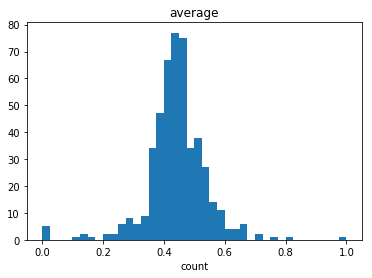

In [13]:
# import the pyplot module from matplotlib
import matplotlib.pyplot as plt

# matplotlib plots inline  
%matplotlib inline

# Plotting distribution of wins
plt.hist(df_players['avg'], bins = 40)
plt.xlabel('count')
plt.title('average')

plt.show()

In [14]:
df_players['avg'].describe()

count    485.000000
mean       0.441730
std        0.099025
min        0.000000
25%        0.399168
50%        0.442387
75%        0.484756
max        1.000000
Name: avg, dtype: float64

In [15]:
df_players = df_players[df_players['avg']>0]
df_players = df_players[df_players['avg']<1]

In [16]:
from scipy.stats import beta
data = list(df_players['avg'])
a1, b1, loc1, scale1 = beta.fit(data, floc=0, fscale=1)
a1, b1

(13.999333617664394, 17.45959631432189)

In [17]:
posterior_avg = pd.DataFrame((df_players['scored'] + a1) / (df_players['total'] + a1 + b1), columns=['poster_avg'])

In [18]:
df_players = pd.merge(df_players, posterior_avg,  on = 'shooter')
df_players.rename(columns={0 :'posterior_avg'})
df_players.head()

,scored,total,avg,poster_avg
shooter,,,,
A.J. Hammons,204,504,0.404762,0.407126
Aaron Brooks,1452,3600,0.403333,0.403694
Aaron Gordon,4716,10368,0.454861,0.454831
Adreian Payne,276,648,0.425926,0.426809
Al Horford,4548,9612,0.473159,0.473067


In [24]:
export_csv = df_players.to_csv('players_dataframe.csv', header=False)

Now, this table is placed on hdfs(/user/oksana_hrytsiv/nba_shots)